# Calculate the seasonal means of errors in MDM and QDM+ sort predictions
- MDM: Moment Delta Mapping
- Consider the MDM operators L_1 and L_2 which map the mean and mean and stdev of a distribution respectively
- MDM error for operator L_i  = [L_i (Q_historical) ] - Q_future
- In this notebook, Q_historical is the pre-industrial quantile function and Q_future is the End of 21st century quantile function
- These quantile functions are constructed from detrended CESM2 LENS data
- We can similarly caluclate errors for the Gaussian operators G1 and G2 (see paper for more details)
- In this notebook, we compute the seasonal mean of the MDM error for various operators

## Section 1: Load functions and start a cluster

In [1]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
import matplotlib.pyplot as plt
import matplotlib as mtplt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
import cartopy as cart
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.special import erfinv, erf
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
# warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

In [2]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [3]:
chic_lat  = 41.8781
chic_lon  = (360-87.6298)%360
ben_lat   = 12.9716
ben_lon   = 77.5946
#SGP
sgp_lat   = 36.605
sgp_lon   = (360-97.485)%360
########## CONUS ############
#CONUS lat-lon
top       = 50.0 # north lat
left      = -124.7844079+360 # west long
right     = -66.9513812+360 # east long
bottom    =  24.7433195 # south lat
################################
rda_scratch = '/glade/campaign/collections/rda/scratch/harshah'
rda_url     =  'https://data.rda.ucar.edu/'
rda_data    = '/glade/campaign/collections/rda/data/harshah/'
#
tmean_path  = rda_data + 'mdm_data/tmean/'
tmax_path   = rda_data + 'mdm_data/tmax/'
tmin_path   = rda_data + 'mdm_data/tmin/'
############
pi_year  = 1865
eoc_year = 2085
#
doy  = 211
#
pi_year0  = '1850'
pi_year1  = '1879'
ic_year0  = '2071'
ic_year1  = '2100'

In [4]:
def to_daily(ds):
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time")  

In [5]:
quants = np.linspace(0,1.0,30)
def compute_quantiles(ds, quantiles=quants):
    return ds.chunk(dict(year=-1)).quantile(quantiles, dim='year',skipna=False)

def implement_mdm(ds_obs,init_mean,final_mean,init_std,final_std):
    # Assuming coordinates year and day for ds_obs
    obs_mean = ds_obs.mean('year')
    sratio   = final_std/init_std
    ds_mdm   = obs_mean + (final_mean - init_mean) + sratio*(ds_obs - obs_mean)        
    return ds_mdm

def implement_shift(ds_obs,init_mean,final_mean):
    # Assuming coordinates year and day for ds_obs
    obs_mean   = ds_obs.mean('year')
    ds_shift   = (final_mean - init_mean) + ds_obs
    return ds_shift

def implement_qdm(qobs, qinit, qfinal):
    # Implement quantile delta mapping. Assumes model data has corrd called 'mtime'
    #qinit    = init_data.quantile(quants,dim='mtime')
    #qfinal   = final_data.quantile(quants,dim='mtime')
    ds_qdm   = qobs + (qfinal - qinit)
    return ds_qdm

def is_sorted(arr):
    return np.all(arr[:-1] <= arr[1:]) or np.all(arr[:-1] >= arr[1:])

In [6]:
def gauss_quantile(mean,std,quantile):
    qvalue = mean + std * np.sqrt(2) * erfinv(2*quantile-1)
    return qvalue

In [7]:
def select_months(data, months):
    """
    Selects data for specific months from an xarray DataArray based on dayofyear and year coordinates.

    Parameters:
    data (xarray.DataArray): The input DataArray with 'dayofyear' and 'year' coordinates.
    months (list of int): List of three months to select (e.g., [12, 1, 2] for DJF).

    Returns:
    xarray.DataArray: Filtered DataArray for the specified months.
    """
    # Define the day ranges for each month assuming a 365-day calendar
    month_ranges = {
        1: (1, 31),   # January
        2: (32, 59),  # February
        3: (60, 90),  # March
        4: (91, 120), # April
        5: (121, 151),# May
        6: (152, 181),# June
        7: (182, 212),# July
        8: (213, 243),# August
        9: (244, 273),# September
        10: (274, 304),# October
        11: (305, 334),# November
        12: (335, 365)# December
    }

    # Get the start and end day of the year for each selected month
    days_to_select = []
    for month in months:
        start_day, end_day = month_ranges[month]
        days_to_select.extend(range(start_day, end_day + 1))

    # Filter the data for the specified days of the year
    filtered_data = data.where(data['dayofyear'].isin(days_to_select), drop=True)

    return filtered_data

In [8]:
def altspace(start, step, count, endpoint=False, **kwargs):
   stop = start+(step*count)
   return np.linspace(start, stop, count, endpoint=endpoint, **kwargs)

In [9]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk25-mdm',
    cores = 1,
    memory = '16GiB',
    processes = 1,
    local_directory = rda_scratch+'/dask/spill',
    log_directory = rda_scratch + '/dask/logs/',
    resource_spec = 'select=1:ncpus=1:mem=16GB',
    queue = 'casper',
    walltime = '5:00:00',
    interface = 'ext'
)

/glade/u/home/harshah/venvs/osdf/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42339 instead
  warnings.warn(


In [10]:
# Create the client to load the Dashboard
client = Client(cluster)

In [11]:
n_workers = 12
cluster.scale(n_workers)
client.wait_for_workers(n_workers = n_workers)
cluster

PBSCluster(440d1ad9, 'tcp://128.117.208.95:32783', workers=12, threads=12, memory=192.00 GiB)

In [12]:
pi_year0 = '1850'
pi_year1 = '1879'
ic_year0 = '2071'
ic_year1 = '2100'
pi_year  = 1865
# eoc_year = 2085 #Central year used for detrending
ic_year  = 2086 #This is the correct year for the rolling window operation to work
doy      = 211 # day_of_year
## Change/Check these parameters before running

## Section 2: Load detrended data

In [13]:
var_name    = 'tmax'
folder_path = tmax_path
det_var     = 'detrended_tmax'
temp_var    = 'TREFHTMX'

In [14]:
pi_detrended  = xr.open_zarr(folder_path + f'pre_ind_detrended_{var_name}.zarr')
eoc_detrended = xr.open_zarr(folder_path + f'eoc_detrended_{var_name}.zarr')
#
pi_detrended = pi_detrended[det_var]
eoc_detrended = eoc_detrended[det_var]
pi_detrended

<xarray.DataArray 'detrended_tmax' (member_id: 100, lat: 192, lon: 288,
                                    year: 30, dayofyear: 365)> Size: 484GB
dask.array<open_dataset-detrended_tmax, shape=(100, 192, 288, 30, 365), dtype=float64, chunksize=(1, 48, 288, 30, 30), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
    degree     int64 8B ...
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 5kB 'r10i1181p1f1' ... 'r9i1171p1f2'
  * year       (year) int64 240B 1850 1851 1852 1853 ... 1876 1877 1878 1879

### Apply MDM, compute quantile funtions and save data

In [15]:
# Compute mean and std over year i.e, annual mean and stds 
pi_amean  = pi_detrended.mean('year')
eoc_amean = eoc_detrended.mean('year')
pi_astd   = pi_detrended.std('year')
eoc_astd  = eoc_detrended.std('year')

In [16]:
pi_mdm = implement_mdm(pi_detrended,pi_amean,eoc_amean,pi_astd,eoc_astd)
# pi_mdm

In [17]:
pi_shift = implement_shift(pi_detrended,pi_amean,eoc_amean)

In [18]:
# %%time
# pi_mdm.rename(var_name).to_dataset().to_zarr(folder_path + f'pre_ind_mdm_{var_name}.zarr',mode='w')

In [19]:
# %%time
# pi_shift.rename(var_name).to_dataset().to_zarr(folder_path + f'pre_ind_shift_{var_name}.zarr',mode='w')

In [20]:
print(folder_path + f'pre_ind_mdm_{var_name}.zarr')

/glade/campaign/collections/rda/data/harshah/mdm_data/tmax/pre_ind_mdm_tmax.zarr


In [21]:
%%time
pi_mdm   = xr.open_zarr(folder_path + f'pre_ind_mdm_{var_name}.zarr')
pi_shift = xr.open_zarr(folder_path + f'pre_ind_shift_{var_name}.zarr')
#
pi_shift = pi_shift[var_name]
pi_mdm   = pi_mdm[var_name]
pi_mdm

CPU times: user 25.8 ms, sys: 0 ns, total: 25.8 ms
Wall time: 39.4 ms


<xarray.DataArray 'tmax' (member_id: 100, lat: 192, lon: 288, dayofyear: 365,
                          year: 30)> Size: 484GB
dask.array<open_dataset-tmax, shape=(100, 192, 288, 365, 30), dtype=float64, chunksize=(1, 48, 288, 30, 30), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
    degree     int64 8B ...
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 5kB 'r10i1181p1f1' ... 'r9i1171p1f2'
  * year       (year) int64 240B 1850 1851 1852 1853 ... 1876 1877 1878 1879

In [22]:
# %%time
# pi_mdm.sel(lat=LAT,lon=LON,method='nearest').sel(member=0,dayofyear=1).values

### Compute quantiles and errors for each season

#### Pick season and months #######

In [23]:
#DJF 
# months         = [12,1,2]
# season         = 'djf'
#
# #MAM
# months         = [3,4,5]
# season         =  'mam'
# #
# #JJA
# months         = [6,7,8]
# season         =  'jja'
#
# #SON
months         = [9,10,11]
season         =  'son'

In [24]:
pi_mdm_season   = select_months(pi_mdm,months)
pi_season       = select_months(pi_detrended,months)
eoc_season      = select_months(eoc_detrended,months)
#
# Compute mean and std over year i.e, annual mean and stds 
pi_amean_season  = select_months(pi_amean,months)
eoc_amean_season = select_months(eoc_amean,months)
pi_astd_season   = select_months(pi_astd,months)
eoc_astd_season  = select_months(eoc_astd,months)
#
pi_shift_season = implement_shift(pi_season,pi_amean_season,eoc_amean_season)
pi_mdm_season

<xarray.DataArray 'tmax' (member_id: 100, lat: 192, lon: 288, dayofyear: 91,
                          year: 30)> Size: 121GB
dask.array<where, shape=(100, 192, 288, 91, 30), dtype=float64, chunksize=(1, 48, 288, 35, 30), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 728B 244 245 246 247 248 ... 331 332 333 334
    degree     int64 8B 1
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 5kB 'r10i1181p1f1' ... 'r9i1171p1f2'
  * year       (year) int64 240B 1850 1851 1852 1853 ... 1876 1877 1878 1879

In [25]:
%%time
qpi_mdm_season   = compute_quantiles(pi_mdm_season)
qpi_shift_season = compute_quantiles(pi_shift_season)
qeoc_season      = compute_quantiles(eoc_season)
qpi_season       = compute_quantiles(pi_season)

CPU times: user 19.6 ms, sys: 0 ns, total: 19.6 ms
Wall time: 38.8 ms


In [49]:
%%time
qmdm_err_season   = qpi_mdm_season   - qeoc_season
qshift_err_season = qpi_shift_season - qeoc_season
#
qmdm_err_season   = qmdm_err_season.chunk({'dayofyear':14})
qshift_err_season = qshift_err_season.chunk({'dayofyear':14})
qshift_err_season

CPU times: user 113 ms, sys: 18 μs, total: 113 ms
Wall time: 151 ms


<xarray.DataArray 'detrended_tmax' (quantile: 30, member_id: 100, lat: 192,
                                    lon: 288, dayofyear: 91)> Size: 121GB
dask.array<rechunk-merge, shape=(30, 100, 192, 288, 91), dtype=float64, chunksize=(30, 1, 48, 288, 14), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 728B 244 245 246 247 248 ... 331 332 333 334
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 5kB 'r10i1181p1f1' ... 'r9i1171p1f2'
  * quantile   (quantile) float64 240B 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [27]:
%%time
print(folder_path + season+f'_mdm_err_{var_name}.zarr')
qmdm_err_season.rename(var_name).to_dataset().to_zarr(folder_path + season+f'_mdm_err_{var_name}.zarr',mode='w')

/glade/campaign/collections/rda/data/harshah/mdm_data/tmax/son_mdm_err_tmax.zarr
CPU times: user 43.4 s, sys: 2.47 s, total: 45.9 s
Wall time: 5min 20s


In [28]:
%%time
qshift_err_season.rename(var_name).to_dataset().to_zarr(folder_path + season+f'_shift_err_{var_name}.zarr',mode='w')

CPU times: user 1min 3s, sys: 3.31 s, total: 1min 6s
Wall time: 6min 8s


In [48]:
## Open files
qmdm_err_season   = xr.open_zarr(folder_path + season+f'_mdm_err_{var_name}.zarr')
qshift_err_season = xr.open_zarr(folder_path + season+f'_shift_err_{var_name}.zarr')
#
qmdm_err_season   = qmdm_err_season[var_name]
qshift_err_season = qshift_err_season[var_name]
qshift_err_season

<xarray.DataArray 'tmax' (quantile: 30, member_id: 100, lat: 192, lon: 288,
                          dayofyear: 91)> Size: 121GB
dask.array<open_dataset-tmax, shape=(30, 100, 192, 288, 91), dtype=float64, chunksize=(30, 1, 48, 288, 14), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 728B 244 245 246 247 248 ... 331 332 333 334
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 5kB 'r10i1181p1f1' ... 'r9i1171p1f2'
  * quantile   (quantile) float64 240B 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [30]:
# qshift_err_season.sel(lat=LAT,lon=LON,method='nearest').sel(member=0,dayofyear=1).values

### Compute Gaussian quantile functions and errors

In [31]:
# Create a DataArray for the quantiles
quantiles = xr.DataArray(np.linspace(0,1.0,30), dims='quantile').assign_coords(quantile=('quantile',quants))

In [32]:
####### Construct gaussians for EOC ################
qgauss_standard_normal        = xr.apply_ufunc(erfinv,2*quantiles-1)
#################
qpi_gauss_season      = eoc_amean_season + eoc_astd_season * np.sqrt(2) *qgauss_standard_normal
# qpi_gauss_season.name = 'qgauss_detrended'
qpi_gauss_season
## gaussmo = gaussian with eoc mean only and pre-ind std
qpi_gaussmo_season      = eoc_amean_season + pi_astd_season * np.sqrt(2) * qgauss_standard_normal      
# qpi_gaussmo_season.name = 'qgaussmo_detrended'
qpi_gaussmo_season

<xarray.DataArray (member_id: 100, lat: 192, lon: 288, dayofyear: 91,
                   quantile: 30)> Size: 121GB
dask.array<add, shape=(100, 192, 288, 91, 30), dtype=float64, chunksize=(1, 48, 288, 35, 30), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 728B 244 245 246 247 248 ... 331 332 333 334
    degree     int64 8B 1
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 5kB 'r10i1181p1f1' ... 'r9i1171p1f2'
  * quantile   (quantile) float64 240B 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [33]:
%%time
qgauss_err_season   = qpi_gauss_season   - qeoc_season
qgaussmo_err_season = qpi_gaussmo_season - qeoc_season
#
# qgauss_err_season.name   = 'qgauss_error'
# qgaussmo_err_season.name = 'qgaussmo_error'
#
qgauss_err_season   = qgauss_err_season.chunk({'member_id':10,'lat':48,'lon':288,'dayofyear':30,'quantile':10})
qgaussmo_err_season = qgaussmo_err_season.chunk({'member_id':10,'lat':48,'lon':288,'dayofyear':30,'quantile':10})
qgauss_err_season

CPU times: user 61.9 ms, sys: 6 μs, total: 61.9 ms
Wall time: 78 ms


<xarray.DataArray (member_id: 100, lat: 192, lon: 288, dayofyear: 91,
                   quantile: 30)> Size: 121GB
dask.array<rechunk-p2p, shape=(100, 192, 288, 91, 30), dtype=float64, chunksize=(10, 48, 288, 30, 10), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 728B 244 245 246 247 248 ... 331 332 333 334
    degree     int64 8B 1
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 5kB 'r10i1181p1f1' ... 'r9i1171p1f2'
  * quantile   (quantile) float64 240B 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [47]:
print(var_name)

tmax


In [46]:
%%time
qgauss_err_season.rename(var_name).to_dataset().to_zarr(folder_path + season+f'_gauss_err_{var_name}.zarr',mode='w')
# qgaussmo_err_season.rename(var_name).to_dataset().to_zarr(folder_path + season+f'_gaussmo_err_{var_name}.zarr',mode='w')

ValueError: the first argument to .rename must be a dictionary

In [35]:
%%time
qgauss_err_season   = xr.open_zarr(folder_path + season+f'_gauss_err_{var_name}.zarr')
qgaussmo_err_season = xr.open_zarr(folder_path + season+f'_gaussmo_err_{var_name}.zarr')
#
qgauss_err_season   = qgauss_err_season[var_name]
qgaussmo_err_season = qgaussmo_err_season[var_name]

FileNotFoundError: No such file or directory: '/glade/campaign/collections/rda/data/harshah/mdm_data/tmax/son_gaussmo_err_tmax.zarr'

### Plot MDM errors

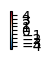

In [36]:
######## New colorbar only for shift + stretch and gaussian ############
x = 5
# create a figure and axis
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
# Define colormap
cmap = plt.get_cmap('RdBu_r')
# Make a norm object with the center at 0: TwoSlopeNorm
norm = mcolors.TwoSlopeNorm(vmin=-x, vcenter=0, vmax=x)
# Making numpy array from -3 to 3, with step 0.2
values = np.arange(-x, x+0.25, 0.25)
# Creating a mappable object and setting the norm and cmap for colorbar
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
# Creating a colorbar
ticks1 = altspace(-4,1,9)
cbar = plt.colorbar(mappable, ax=ax, orientation='vertical',ticks=ticks1)
cbar.set_label('')
plt.gca().set_visible(False)

In [44]:
# %%time
member =0 
# # Creating a figure and axes
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), subplot_kw={'projection': cart.crs.PlateCarree()}\
#                        , gridspec_kw = {'wspace':0.05, 'hspace':0.2})

# # Plotting qgmsc_err
# qmdm_err_season.sel(quantile=0.9,method='nearest').isel(member_id=member).mean('dayofyear').plot(ax=axs[0], transform=cart.crs.PlateCarree(),\
#                                                     add_colorbar=False, cmap=cmap, norm=norm)
# axs[0].coastlines(color="black")
# axs[0].set_title(season+r': $L_2(Q_h) - Q_f$ at $p=0.9$')

# # Plotting G2, gaussian error
# im = qgauss_err_season.sel(quantile=0.9,method='nearest').isel(member_id=member).mean('dayofyear').plot(ax=axs[1], transform=cart.crs.PlateCarree(),\
#                                                           add_colorbar=False, cmap=cmap, norm=norm)
# axs[1].coastlines(color="black")
# axs[1].set_title(season+': $G_2(Q_h) - Q_f$ at $p=0.9$')

# # Adding colorbar
# cbar = plt.colorbar(im, ax=axs.ravel().tolist(), shrink=0.5, orientation='vertical')
# cbar.set_label('Error')

# plt.show()

RuntimeError: P2P 5ebd396b96d39f7bf7040d686462b98a failed during transfer phase

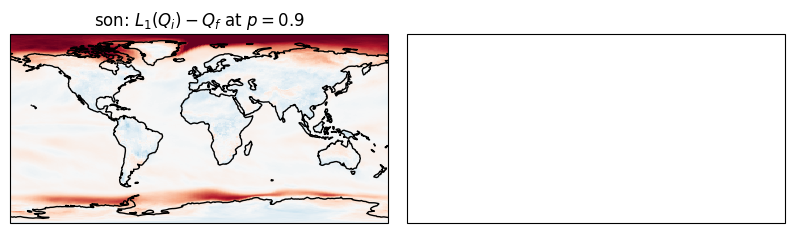

In [45]:
%%time
# Creating a figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), subplot_kw={'projection': cart.crs.PlateCarree()}\
                       , gridspec_kw = {'wspace':0.05, 'hspace':0.2})

# Plotting qgmsc_err
qshift_err_season.sel(quantile=0.9,method='nearest').isel(member_id=member).mean('dayofyear').plot(ax=axs[0], transform=cart.crs.PlateCarree(),\
                                                    add_colorbar=False, cmap=cmap, norm=norm)
axs[0].coastlines(color="black")
axs[0].set_title(season+': $L_1(Q_i) - Q_f$ at $p=0.9$')

# Plotting da2
im = qgaussmo_err_season.sel(quantile=0.9,method='nearest').isel(member_id=member).mean('dayofyear').plot(ax=axs[1], transform=cart.crs.PlateCarree(),\
                                                          add_colorbar=False, cmap=cmap, norm=norm)
axs[1].coastlines(color="black")
axs[1].set_title(season+r': $G_1(Q_i) - Q_f$ at $p=0.9$')

# Adding colorbar
cbar = plt.colorbar(im, ax=axs.ravel().tolist(), shrink=0.5, orientation='vertical')
cbar.set_label('Errors')

plt.show()

### Compute ensemble mean of absolute errors

In [39]:
qmdm_abserr_season     = np.abs(qmdm_err_season)
qshift_abserr_season   = np.abs(qshift_err_season)
qgauss_abserr_season   = np.abs(qgauss_err_season)
qgaussmo_abserr_season = np.abs(qgaussmo_err_season)

In [40]:
%%time
qmdm_abserr_season.mean('member_id').rename(var_name).to_dataset().to_zarr(folder_path + season+f'_mdm_abserr_emean_{var_name}.zarr',mode='w')
qshift_abserr_season.mean('member_id').rename(var_name).to_dataset().to_zarr(folder_path + season+f'_shift_abserr_emean_{var_name}.zarr',mode='w')

CPU times: user 19.4 s, sys: 709 ms, total: 20.1 s
Wall time: 1min 35s


In [41]:
# %%time
# qgauss_abserr_season.mean('member_id').rename(var_name).to_dataset().to_zarr(folder_path + season+f'_gauss_abserr_emean_{var_name}.zarr',mode='w')
# qgaussmo_abserr_season.mean('member_id').rename(var_name).to_dataset().to_zarr(folder_path + season+f'_gaussmo_abserr_emean_{var_name}.zarr',mode='w')

In [42]:
# cluster.close()

In [43]:
#############################################################################################################